In [213]:
import numpy as np
import matplotlib.pyplot as plt

import skimage
from PIL import Image
from skimage import transform, morphology, feature, filters
from scipy.ndimage.interpolation import shift
from tqdm import tqdm_notebook
from sys import getsizeof
from sklearn import neighbors, model_selection, ensemble, neural_network
from itertools import product

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import pickle

In [21]:
plt.rcParams['figure.figsize'] = (10, 15)

In [22]:
def open_photo(path):
    im = Image.open(path)
    im = im.convert('L')
    im = np.asarray(im)
    im = transform.resize(im, (150, 150))
    return im

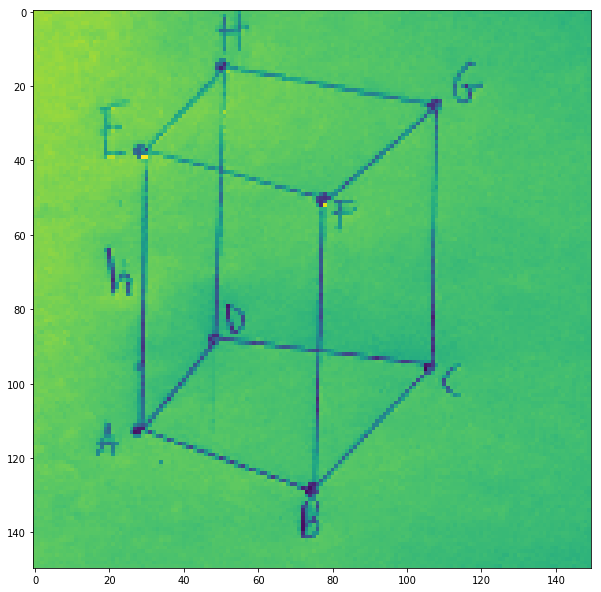

In [23]:
plt.imshow(open_photo("data/originals/PRISM1.jpg"))

### Generate samples

In [24]:
angles = np.arange(-15, 15 + 1, 7.5)
shift_x = np.arange(-30, 30 + 1, 15)
shift_y = shift_x
fliplr = [True, False]
rescale_x = np.arange(0.6, 1 + 0.1, 0.4)
rescale_y = rescale_x

In [25]:
combinations = list(product(angles, shift_x, shift_y, fliplr, rescale_x, rescale_y))
len(combinations)

1000

In [26]:
def modify_photo(img, angle, shift_x, shift_y, fliplr, rescale_x, rescale_y):
    # rescale y
    rescaled_y = transform.rescale(img, (rescale_y, 1))
    background = np.ones((int(np.ceil(150 * (1 - rescale_y) * 0.5)), 150)) * np.mean(im)
    img = np.concatenate((background, rescaled_y, background), axis=0)
    
    # rescale x
    rescaled_x = transform.rescale(img, (1, rescale_x))
    background = np.ones((150, int(np.ceil(150 * (1 - rescale_x) * 0.5)))) * np.mean(im)
    img = np.concatenate((background, rescaled_x, background), axis=1)
    
    # rotate
    img = transform.rotate(img, 5, cval=np.mean(img))
    
    # shift
    img = shift(img, (shift_x, shift_y), cval=np.mean(im))
    
    # flip
    if fliplr:
        img = np.fliplr(img)
    
    fname = f"{angle}-{shift_x}-{shift_y}-{fliplr}-{rescale_x}-{rescale_y}"
    # plt.imsave(f"data/syntetic/{fname}.jpg", img)
    return img

In [31]:
prism_paths = [
    f"data/originals/PRISM{i}.jpg"
    for i in range(1, 10)
]

In [33]:
prisms_images = []
for prism_path in prism_paths:
    im = open_photo(prism_path)
    for i in tqdm_notebook(range(len(combinations))):
        prisms_images.append(
            modify_photo(im, *combinations[i])
        )

/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [34]:
pyramid_paths = [
    f"data/originals/PYRAMIDE{i}.jpg"
    for i in range(1, 11)
]

In [35]:
pyramids_images = []
for pyramid_path in pyramid_paths:
    im = open_photo(pyramid_path)
    for i in tqdm_notebook(range(len(combinations))):
        pyramids_images.append(
            modify_photo(im, *combinations[i])
        )

/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


### Preprocess samples

In [115]:
def preprocess(img):
    threshold = filters.threshold_otsu(img)
    img = img < threshold
    img = morphology.binary_dilation(img)
    img = transform.resize(img, (50, 50))
    return img

In [116]:
preprocessed_prisms = [preprocess(prism) for prism in prisms_images]

/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [117]:
preprocessed_pyramids = [preprocess(pyramid) for pyramid in pyramids_images]

In [118]:
X_prisms = np.array([prism.flatten() for prism in preprocessed_prisms])
x, y = X_prisms.shape
Xy_prisms = np.zeros((x, y+1))
Xy_prisms[:, :-1] = X_prisms

In [119]:
X_pyramids = np.array([pyramid.flatten() for pyramid in preprocessed_pyramids])
x, y = X_pyramids.shape
Xy_pyramids = np.ones((x, y+1))
Xy_pyramids[:, :-1] = X_pyramids

### Classification

In [65]:
Xy = np.concatenate((Xy_prisms, Xy_pyramids))
np.random.shuffle(Xy)
X = Xy[:, :-1]
y = Xy[:, -1]

In [66]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

#### KNN

In [172]:
knn = neighbors.KNeighborsClassifier(100)

In [173]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [55]:
knn.score(X_test, y_test)

0.9673684210526315

#### Random Forest

In [180]:
rf = ensemble.RandomForestClassifier()

In [181]:
rf.fit(X_train, y_train)

/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [182]:
rf.score(X_test, y_test)

0.9991228070175439

#### NN

In [194]:
nn = neural_network.MLPClassifier((50, 50), solver='lbfgs', alpha=1e-5)

In [195]:
nn.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [196]:
nn.score(X_test, y_test)

0.9991228070175439

### Test and save model

/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bartek/.pyenv/versions/3.6.1/envs/woarld/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


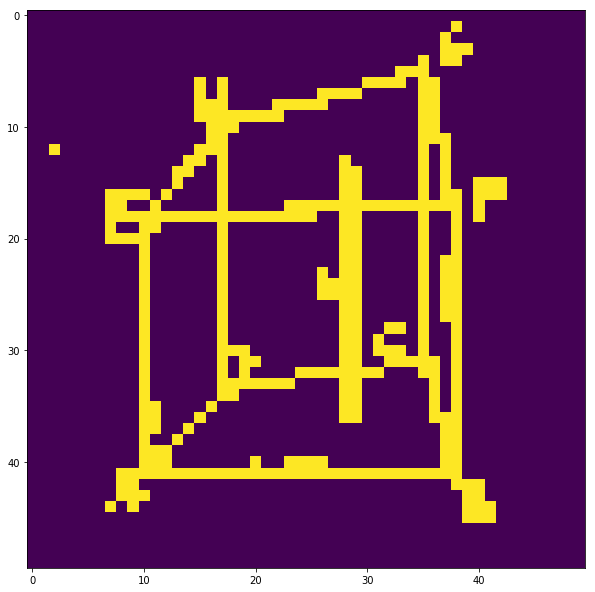

In [211]:
test_image = open_photo("data/test/pioo.jpg")
test_image = preprocess(test_image)
plt.imshow(test_image)

In [212]:
nn.predict_proba(test_image.reshape(1, -1))

array([[1.00000000e+00, 1.88571509e-13]])

In [215]:
with open("nn_model.pickle", "wb") as f:
    pickle.dump(nn, f)